# Convolutional VAE

In this notebook we implement a convolutional VAE to model the distributions of MNIST and CIFAR10. We train the model for around 10 epochs for each. 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from cvae import *

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
train_dataset = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)
mnist_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
train_dataset = datasets.CIFAR10(root="data", train=True, transform=transform, download=True)
cifar_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_dim, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.net = nn.Sequential(
            nn.Conv2d(in_dim, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4096, 2*latent_dim)
        )

    def forward(self, x):
        x = self.net(x)
        mu, log_std = torch.chunk(x, 2, dim=1)
        return mu, log_std

class Decoder(nn.Module):
    def __init__(self, out_dim, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 2048),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, out_dim, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.net(z)
        return x

In [ ]:
class VAE(nn.Module):
    def __init__(self, in_dim, latent_dim, device="cpu"):
        super(VAE, self).__init__()
        self.encoder = Encoder(in_dim, latent_dim)
        self.decoder = Decoder(in_dim, latent_dim)
        self.latent_dim = latent_dim
        self.device = device

    def forward(self, x):
        self.channels, self.height, self.width = x.shape[1:]
        mu_x, log_std_x = self.encoder(x)
        eps = torch.randn_like(mu_x)
        z = mu_x + log_std_x.exp() * eps
        x_recon = self.decoder(z)
        x_recon = torch.clamp(x_recon, -1, 1)
        return x_recon, mu_x, log_std_x

    def sample(self, n_samples):
        self.eval()
        z = torch.randn(n_samples, self.latent_dim).to(self.device)
        samples = self.decoder(z)
        samples = torch.clamp((samples + 1)/2, 0, 1)
        samples = samples.permute(0, 2, 3, 1)
        samples = samples.detach().cpu().numpy()
        return samples

In [ ]:
def loss_fn(x, x_recon, mu, log_std):
    recon_loss = F.mse_loss(x, x_recon, reduction='none').view(x.shape[0], -1).sum(dim=1).mean()
    kl_loss = -0.5 * torch.sum(1 + 2 * log_std - mu.pow(2) - (2 * log_std).exp(), dim=1).mean()
    loss = recon_loss + kl_loss
    return loss, kl_loss, recon_loss

## VAE On MNIST

In [ ]:
vae = VAE(in_dim=1, latent_dim=256, device=DEVICE).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
train(vae, optimizer, mnist_train_loader, 10)

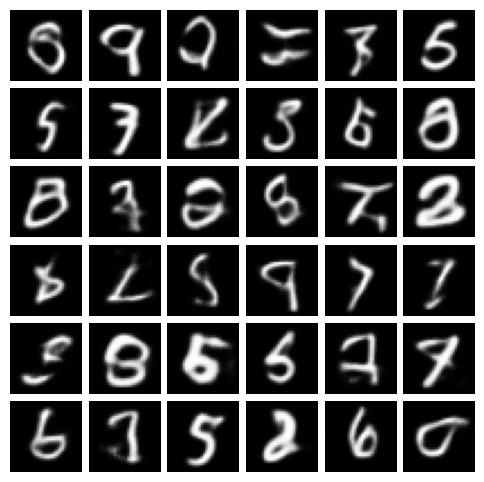

In [ ]:
plot_samples(vae, 36, device=DEVICE)

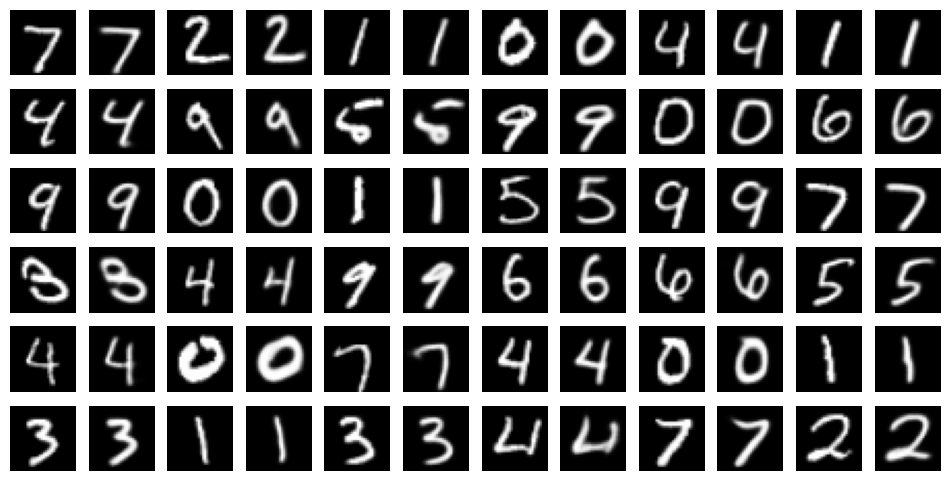

In [ ]:
plot_reconstruction(model, test_loader, device=DEVICE)

## VAE on CIFAR10

In [ ]:
vae = VAE(256, device=DEVICE).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
train(vae, optimizer, train_loader, 10)

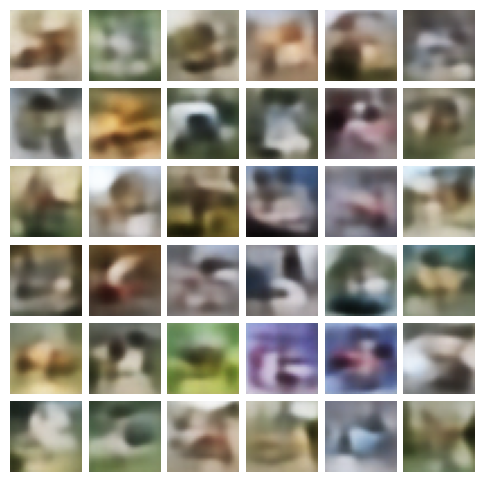

In [ ]:
plot_samples(vae, 36, device=DEVICE)

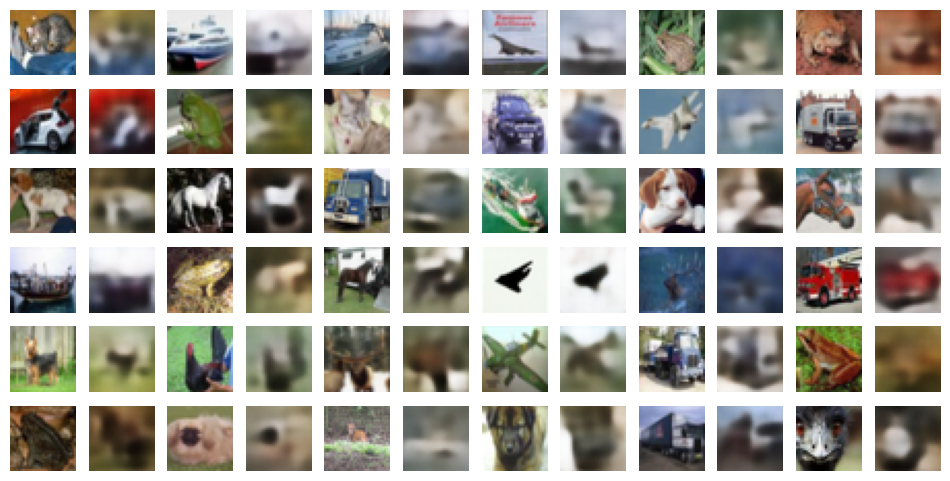

In [ ]:
plot_reconstruction(model, test_loader, device=DEVICE)